<a href="https://colab.research.google.com/github/Haizhuolaojisite/FastText-Semantic-Similarity-and-Text-Classification/blob/main/fasttext_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install wikipedia

In [2]:
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Scraping Wikipedia Articles

In [8]:

artificial_intelligence = wikipedia.page("Artificial Intelligence").content
machine_learning = wikipedia.page("MachineLearning").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

# The sent_tokenize method returns list of sentences
artificial_intelligence = sent_tokenize(artificial_intelligence)
machine_learning = sent_tokenize(machine_learning)
deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

# sentences from the four articles are joined together via the extend method
artificial_intelligence.extend(machine_learning)
artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

# Data Preprocessing
The next step is to clean our text data by removing punctuations and numbers. We will also convert the data into the lower case. The words in our data will be lemmatized to their root form. Furthermore, the stop words and the words with the length less than 4 will be removed from the corpus.

In [9]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [10]:
sent = preprocess_text("Artificial intelligence, is the most advanced technology of the present era")
print(sent)

# The strip() method removes any leading (spaces at the beginning) and trailing (spaces at the end) characters (space is the default leading character to remove)
final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

artificial intelligence advanced technology present


# Creating Words Representation

 The window_size is the size of the number of words occurring before and after the word based on which the word representations will be learned for the word. This might sound tricky, however in the skip-gram model we input a word to the algorithm and the output is the context words. If the window size is 40, for each input there will be 80 outputs: 40 words that occur before the input word and 40 words that occur after the input word. The word embeddings for the input word are learned using these 80 output words.

In [12]:
# Hyperparameters
# the size of the embedding vector. In other words, each word in our corpus will be represented as a 60-dimensional vector
embedding_size = 60
window_size = 40
#  minimum frequency of a word in the corpus for which the word representations will be generated
min_word = 5
# most frequently occurring word will be down-sampled by a number specified by the down_sampling attribute
down_sampling = 1e-2

sg parameter defines the type of model that we want to create. A value of 1 specifies that we want to create skip-gram model. Whereas zero specifies the bag of words model, which is the default value as well.



In [13]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

CPU times: user 1min 14s, sys: 274 ms, total: 1min 14s
Wall time: 43.6 s


In [14]:
# word representation for the word "artificial"
print(ft_model.wv['artificial'])

[ 0.3230101   0.6593738   0.06713545 -0.36494565 -0.3663365  -0.2500834
  0.21393697  0.01291717  0.44985157 -0.5640005  -0.1870308   0.02447853
 -0.15717205  0.24037187 -0.17830859  0.55571    -0.5837738  -0.5156426
  0.46179357 -0.07073807 -0.02302236  0.30522376  0.07981881  0.12179226
  0.07562064  0.23015459 -0.20068336 -0.43400612 -0.085074   -0.16118324
 -0.25569078  0.28557926  0.01267226  0.18720098 -0.26361385  0.00833027
  0.3379947  -0.14833906 -0.07901882 -0.35918897  0.10511717 -0.31783596
  0.09336255 -0.10391897 -0.09166489 -0.01505258  0.66464865 -0.26449314
 -0.03847535  0.01329867 -0.3010621   0.6220512  -0.50436234 -0.13396011
  0.16681775  0.24672617  0.24850565  0.05640783 -0.46652815  0.4625896 ]


In [15]:
# find top 5 most similar words for the words 'artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep'. You can chose any number of words
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

artificial:['intelligence', 'inspired', 'moral', 'neuron', 'simulated']
intelligence:['artificial', 'intelligent', 'moral', 'creating', 'human']
machine:['learning', 'ethic', 'international', 'source', 'intelligence']
network:['neural', 'recurrent', 'convolutional', 'biological', 'deep']
recurrent:['network', 'neural', 'convolutional', 'published', 'feedforward']
deep:['generative', 'speech', 'specifically', 'network', 'cnns']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [16]:
# We can also find the cosine similarity between the vectors for any two words, as shown below:
print(ft_model.wv.similarity(w1='artificial', w2='intelligence'))
# The value can be anywhere between 0 and 1. A higher value means higher similarity.


0.75801986


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Visualizing Word Similarities
Though each word in our model is represented as 60-dimensional vector, we can use principal component analysis technique to find two principal components. The two principal components can then be used to plot the words in a two dimensional space. However, first we need to create a list of all the words in the semantically_similar_words dictionary. The following script does that:

In [19]:
from sklearn.decomposition import PCA

all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['artificial', 'intelligence', 'inspired', 'moral', 'neuron', 'simulated', 'intelligence', 'artificial', 'intelligent', 'moral', 'creating', 'human', 'machine', 'learning', 'ethic', 'international', 'source', 'intelligence', 'network', 'neural', 'recurrent', 'convolutional', 'biological', 'deep', 'recurrent', 'network', 'neural', 'convolutional', 'published', 'feedforward', 'deep', 'generative', 'speech', 'specifically', 'network', 'cnns']
<class 'list'>
36


In the script above, we iterate through all the key-value pairs in the semantically_similar_words dictionary. Each key in the dictionary is a word. The corresponding value is a list of all semantically similar words. Since we found the top 5 most similar words for a list of 6 words i.e. 'artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep', you will see that there will be 30 items in the all_similar_words list.

Next, we have to find the word vectors for all these 30 words, and then use PCA to reduce the dimensions of the word vectors from 60 to 2. We can then use the plt method, which is an alias of the matplotlib.pyplot method to plot the words on a two-dimensional vector space.

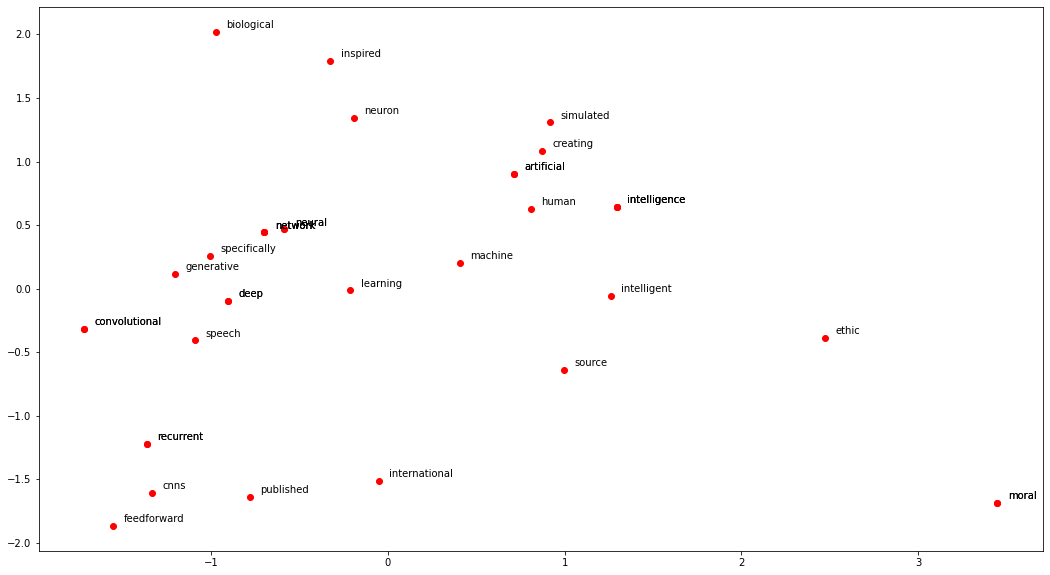

In [20]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

# xy:The point (x,y) to annotate; xytext:The position (x,y) to place the text at. If None, defaults to xy.
for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

You can see the words that frequently occur together in the text are close to each other in the two dimensional plane as well. For instance, the words "deep" and "network" are almost overlapping. Similarly, the words "feedforward" and "backpropagation" are also very close.


# FastText for Text Classification

Text classification refers to classifying textual data into predefined categories based on the contents of the text. Sentiment analysis, spam detection, and tag detection are some of the most common examples of use-cases for text classification.

FastText text classification module can only be run via Linux or OSX. If you are a Windows user, you can use Google Colaboratory to run FastText text classification module. 

The dataset contains multiple files, but we are only interested in the yelp_review.csv file. The file contains more than 5.2 million reviews about different businesses including restaurants, bars, dentists, doctors, beauty salons, etc. However, we will only be using the first 50,000 records to train our model due to memory constraints. 

In [35]:
import pandas as pd
import numpy as np

yelp_reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/yelp.csv")

bins = [0,2,5]
review_names = ['negative', 'positive']

yelp_reviews['reviews_score'] = pd.cut(yelp_reviews['stars'], bins, labels=review_names)

yelp_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,reviews_score
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,positive
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,positive
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,positive
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,positive
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,positive


The next step is to import FastText models, which can be imported using the wget command from the GitHub repository, as shown in the following script:

Note: If you are executing the above command from a Linux terminal, you don't have to prefix ! before the above command. In Google Colaboratory notebook, any command after the ! is executed as a shell command and not within the Python interpreter. Hence all non-Python commands here are prefixed by !.

In [23]:
!wget https://github.com/facebookresearch/fastText/archive/v0.1.0.zip

--2020-12-14 16:58:32--  https://github.com/facebookresearch/fastText/archive/v0.1.0.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.1.0 [following]
--2020-12-14 16:58:33--  https://codeload.github.com/facebookresearch/fastText/zip/v0.1.0
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.1.0.zip’

v0.1.0.zip              [ <=>                ]  92.06K  --.-KB/s    in 0.02s   

2020-12-14 16:58:33 (3.63 MB/s) - ‘v0.1.0.zip’ saved [94267]



The next step is to unzip FastText modules. Simply type the following command:

In [24]:
!unzip v0.1.0.zip

Archive:  v0.1.0.zip
431c9e2a9b5149369cc60fb9f5beba58dcf8ca17
   creating: fastText-0.1.0/
  inflating: fastText-0.1.0/.gitignore  
  inflating: fastText-0.1.0/CONTRIBUTING.md  
  inflating: fastText-0.1.0/LICENSE  
  inflating: fastText-0.1.0/Makefile  
  inflating: fastText-0.1.0/PATENTS  
  inflating: fastText-0.1.0/README.md  
  inflating: fastText-0.1.0/classification-example.sh  
  inflating: fastText-0.1.0/classification-results.sh  
  inflating: fastText-0.1.0/eval.py  
  inflating: fastText-0.1.0/get-wikimedia.sh  
  inflating: fastText-0.1.0/pretrained-vectors.md  
  inflating: fastText-0.1.0/quantization-example.sh  
  inflating: fastText-0.1.0/quantization-results.sh  
   creating: fastText-0.1.0/src/
  inflating: fastText-0.1.0/src/args.cc  
  inflating: fastText-0.1.0/src/args.h  
  inflating: fastText-0.1.0/src/dictionary.cc  
  inflating: fastText-0.1.0/src/dictionary.h  
  inflating: fastText-0.1.0/src/fasttext.cc  
  inflating: fastText-0.1.0/src/fasttext.h  
  inflat

Next, you have to navigate to the directory where you downloaded FastText and then execute the !make command to run C++ binaries. Execute the following steps:

In [30]:
%cd fastText-0.1.0
!make

/content/fastText-0.1.0
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/args.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/dictionary.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/productquantizer.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/matrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/qmatrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/vector.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/model.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/utils.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/fasttext.cc
c++ -pthread -std=c++0x -O3 -funroll-loops args.o dictionary.o productquantizer.o matrix.o qmatrix.o vector.o model.o utils.o fasttext.o src/main.cc -o fasttext


To verify the installation, execute the following command:

In [31]:
!./fasttext

usage: fasttext <command> <args>

The commands supported by fasttext are:

  supervised              train a supervised classifier
  quantize                quantize a model to reduce the memory usage
  test                    evaluate a supervised classifier
  predict                 predict most likely labels
  predict-prob            predict most likely labels with probabilities
  skipgram                train a skipgram model
  cbow                    train a cbow model
  print-word-vectors      print word vectors given a trained model
  print-sentence-vectors  print sentence vectors given a trained model
  nn                      query for nearest neighbors
  analogies               query for analogies



Before we train FastText models to perform text classification, it is pertinent to mention that FastText accepts data in a special format, which is as follows:

_label_tag This is sentence 1
_label_tag2 This is sentence 2.
If we look at our dataset, it is not in the desired format. The text with positive sentiment should look like this:

\__label__positive burgers are very big portions here.
Similarly, negative reviews should look like this:

\__label__negative They do not use organic ingredients, but I thi...

In [36]:
import pandas as pd
from io import StringIO
import csv

# filters the reviews_score and text columns from the dataset 
col = ['reviews_score', 'text']
# prefixes __label__ before all the values in the reviews_score column
yelp_reviews['reviews_score'] = ['__label__'+ s for s in yelp_reviews['reviews_score']]
#  the \n and \t are replaced by a space in the text column
yelp_reviews['text']= yelp_reviews['text'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
#  the updated dataframe is written to the disk in the form of yelp_reviews_updated.txt
yelp_reviews.to_csv(r'/content/drive/MyDrive/Colab Notebooks/yelp_reviews_updated.txt', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [37]:
yelp_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,reviews_score
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,__label__positive
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,__label__positive
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,__label__positive
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,__label__positive
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,__label__positive


In [38]:
yelp_reviews.shape

(10000, 11)

The following script divides the data into training and test sets:



In [43]:
!head -n 8000 "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_updated.txt" > "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_train.txt"
!tail -n 2000 "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_updated.txt" > "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_test.txt"

Now is the time to train our FastText text classification algorithm.

To train the algorithm we have to use supervised command and pass it the input file. The model name is specified after the -output keyword. The above script will result in a trained text classification model called model_yelp_reviews.bin

In [44]:
%%time
!./fasttext supervised -input "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_train.txt" -output model_yelp_reviews


Read 1M words
Number of words:  89225
Number of labels: 2
Progress: 100.0%  words/sec/thread: 3098868  lr: 0.000000  loss: 0.279750  eta: 0h0m 
CPU times: user 26.4 ms, sys: 27 ms, total: 53.4 ms
Wall time: 5.6 s


take a look at the model via !ls command as shown below:

In [45]:
!ls

args.o			   Makefile		    quantization-results.sh
classification-example.sh  matrix.o		    README.md
classification-results.sh  model.o		    src
CONTRIBUTING.md		   model_yelp_reviews.bin   tutorials
dictionary.o		   model_yelp_reviews.vec   utils.o
eval.py			   PATENTS		    vector.o
fasttext		   pretrained-vectors.md    wikifil.pl
fasttext.o		   productquantizer.o	    word-vector-example.sh
get-wikimedia.sh	   qmatrix.o
LICENSE			   quantization-example.sh


Finally, to test the model you can use the test command. You have to specify the model name and the test file after the test command, as shown below:

In [46]:
!./fasttext test model_yelp_reviews.bin "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_test.txt"


N	2000
P@1	0.939
R@1	0.939
Number of examples: 2000


Here P@1 refers to precision and R@1refers to recall. You can see our model achieves precision and recall of 0.939 which is pretty good.

Let's now try to clean our text of punctuations, special characters, and convert it into the lower case to improve the uniformity of text. 


In [47]:
!cat "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_train.txt" | sed -e "s/\([.\!?,’/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_train_clean.txt"

And the following script cleans the test set:


In [48]:
!cat "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_test.txt" | sed -e "s/\([.\!?,’/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_test_clean.txt"

In [51]:
%%time
!./fasttext supervised -input "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_train_clean.txt" -output model_yelp_reviews

Read 1M words
Number of words:  53403
Number of labels: 2
Progress: 100.0%  words/sec/thread: 3465941  lr: 0.000000  loss: 0.256640  eta: 0h0m 
CPU times: user 45.1 ms, sys: 26.2 ms, total: 71.2 ms
Wall time: 3.99 s


In [52]:
!./fasttext test model_yelp_reviews.bin "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_test_clean.txt"

N	2000
P@1	0.939
R@1	0.939
Number of examples: 2000


To further improve the model, you can increase the epochs and learning rate of the model. The following script sets the number of epochs to 30 and learning rate to 0.5.

In [53]:
%%time
!./fasttext supervised -input "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_train_clean.txt" -output model_yelp_reviews -epoch 30 -lr 0.5

Read 1M words
Number of words:  53403
Number of labels: 2
Progress: 100.0%  words/sec/thread: 3511181  lr: 0.000000  loss: 0.059096  eta: 0h0m 
CPU times: user 112 ms, sys: 45.9 ms, total: 158 ms
Wall time: 8.91 s


In [54]:
!./fasttext test model_yelp_reviews.bin "/content/drive/MyDrive/Colab Notebooks/yelp_reviews_test_clean.txt"

N	2000
P@1	0.949
R@1	0.949
Number of examples: 2000


You can see the precision and recall scores are increasesd!

FastText model has recently been proved state of the art for word embeddings and text classification tasks on many datasets. It is very easy to use and lightning fast as compared to other word embedding models.